# **Generating 2 year forecast of genre popularity**

### **Importing libraries**
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # chooses best value for p,d,q 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

import warnings
warnings.filterwarnings("ignore")


### **Data Loading and pre-processing**
---


In [2]:
# time series data
df = pd.read_csv('/Users/vidhiparmar/Desktop/projects/future_genre/trend_data/trend_df.csv')

In [3]:
# preprocessing the dataframe
df.drop('r and b music', axis= 1, inplace= True) # not sufficient variation in the column - r and b music
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace= True)

In [4]:
df.dtypes

hip hop music        int64
pop music            int64
country music        int64
rock music           int64
alternative music    int64
kpop music           int64
metal music          int64
latin music          int64
indie music          int64
dtype: object

### **Exploratory Data Analysis**
---

In [5]:
print(f'Top 5 rows:\n{df.head()}\n')
print(f'Summary Stats:\n{df.describe()}\n')
print(f'Missing null values:\n{df.isna().sum()}')

Top 5 rows:
            hip hop music  pop music  country music  rock music  \
date                                                              
2018-01-01             11         23             56          31   
2018-02-01             11         23             61          32   
2018-03-01             11         23             59          32   
2018-04-01             10         23             69          31   
2018-05-01             10         22             57          30   

            alternative music  kpop music  metal music  latin music  \
date                                                                  
2018-01-01                 41          24           67           43   
2018-02-01                 40          23           69           47   
2018-03-01                 38          22           69           46   
2018-04-01                 40          23           64           57   
2018-05-01                 36          23           64           46   

            indie mu

### **Extracting each genre data as a Pandas Series object.** 
---

In [6]:
hiphop = df['hip hop music']
pop = df['pop music']
country = df['country music']
rock = df['rock music']
alter = df['alternative music']
kpop = df['kpop music']
metal = df['metal music']
latin = df['latin music']
indie = df['indie music']

# **Hip hop music**
> Genre Status: Declining but stabilizing <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,1,1)(1,0,1)[12] <br>

### **Stationarity Check** 
---

In [7]:
# Stationarity check 
result = adfuller(hiphop)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.9786153985808255
p-value: 0.2960274892539917


Hip Hop's popularity trend is non-stationary

### **Seasonality Check** 
---
We decompose each genre's trend line to see if there's a repeating seasonal pattern. 
This informs our decision to apply seasonal modeling like SARIMA.

Visuals below show whether hip hop has consistent yearly trends.

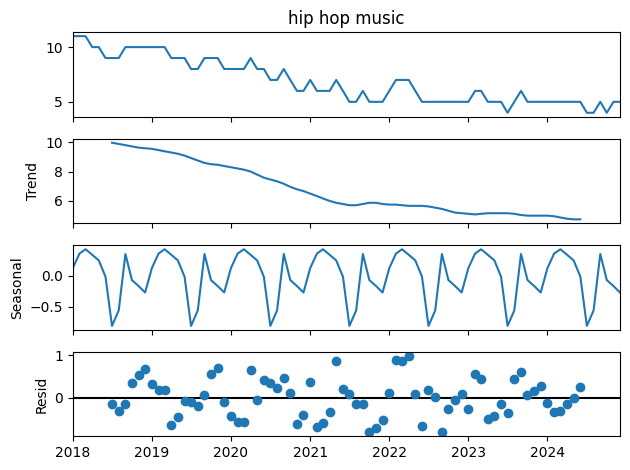

Seasonal Strength: 0.417994126546231


In [8]:
result = seasonal_decompose(hiphop, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)


**RESULT:** <br> 

This is moderate-to-weak seasonality — not zero, but not dominant either. So while there are some recurring annual patterns (like spikes around summer releases or award season), they don’t define the genre's trajectory.


### **Splitting training and test dataset**
---

In [9]:
train = hiphop.iloc[:-12]
test = hiphop.iloc[-12:]

### **Auto_arima model selection**
---
We use *auto_arima()* to automatically determine the best SARIMA parameters for forecasting.

- **seasonal=True** → Enables seasonal modeling
- **m=12** → Specifies monthly data with yearly seasonality (12 months per cycle)
- **trace=True** → Outputs the step-by-step model evaluation
- The model is selected based on **lowest AIC** (Akaike Information Criterion)

This step helps us avoid manual trial-and-error in parameter tuning.


In [10]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=137.739, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=143.114, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=142.750, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=142.125, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=142.324, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=138.703, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=138.282, Time=0.13 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=140.575, Time=0.50 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=140.126, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=139.051, Time=0.03 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=140.243, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=139.816, Time=0.33 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=135.548, Time=0.25 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=136.722, Time=0.06 sec
 ARIMA(1,1,2)(

**RESULT:** <br>

- **ARIMA(1,1,1)** → The non-seasonal part of the model has:
- **Seasonal Order (1, 0, 1, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **SARIMA Modeling and Forecasting**
---

                                     SARIMAX Results                                      
Dep. Variable:                      hip hop music   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -51.755
Date:                            Sun, 25 May 2025   AIC                            113.510
Time:                                    13:15:25   BIC                            123.726
Sample:                                01-01-2018   HQIC                           117.480
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5954      0.164      3.640      0.000       0.275       0.916
ma.L1         -1.0000    182.795   

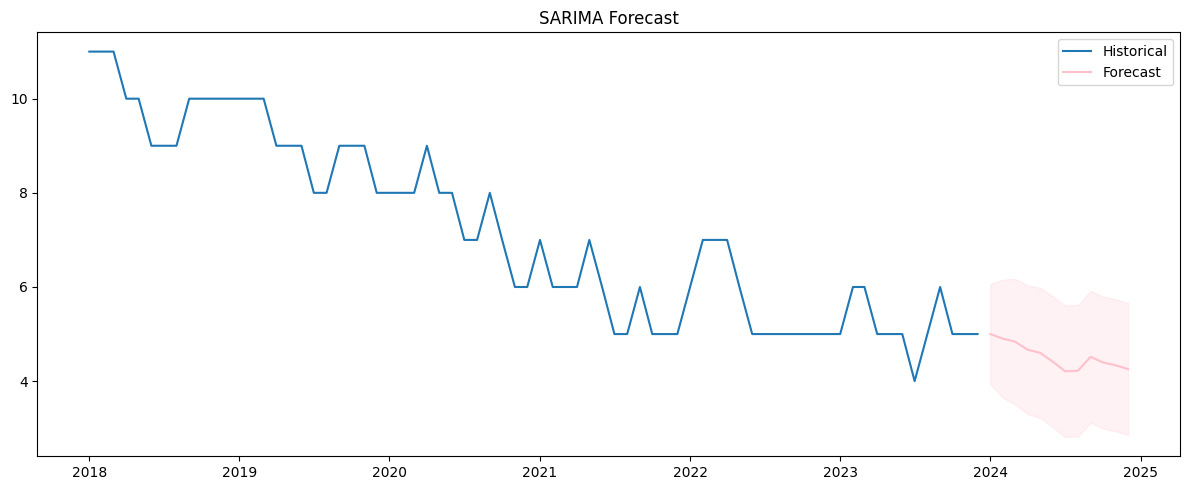

In [11]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(train, 
                order=(1, 1, 1), # (p, d, q)
                seasonal_order=(1, 0, 1, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
hiphop_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, hiphop_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 0.36
RMSE: 0.42
MAPE: 7.50%


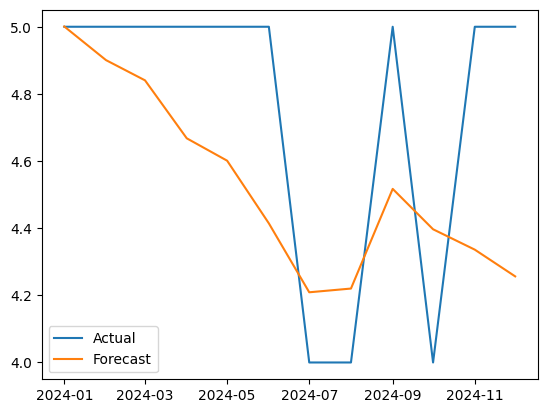

In [12]:
# Actual and predicted values
y_true = test
y_pred = hiphop_forecast 

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, y_pred, label='Forecast')
plt.legend()

**Result:** <br>
- The SARIMA model demonstrates a strong overall fit, with performance metrics indicating high predictive accuracy and stability:

- Mean Absolute Error (MAE): 0.36 - On average, predictions deviate by just 0.36 units from actual values.
- Root Mean Squared Error (RMSE): 0.42 - Captures both the magnitude and variability of errors — low RMSE confirms consistent performance.
- Mean Absolute Percentage Error (MAPE): 7.5% - Indicates that, on average, predictions are within 7.5% of actual values.

This is considered excellent, especially in cultural or behavioral time series, where achieving <10% MAPE is rare due to inherent volatility.


### **Forecasting 2025 & 2026**
---

                                     SARIMAX Results                                      
Dep. Variable:                      hip hop music   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -59.035
Date:                            Sun, 25 May 2025   AIC                            128.071
Time:                                    13:15:25   BIC                            139.241
Sample:                                01-01-2018   HQIC                           132.502
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5067      0.154      3.294      0.001       0.205       0.808
ma.L1         -0.8990      0.121   

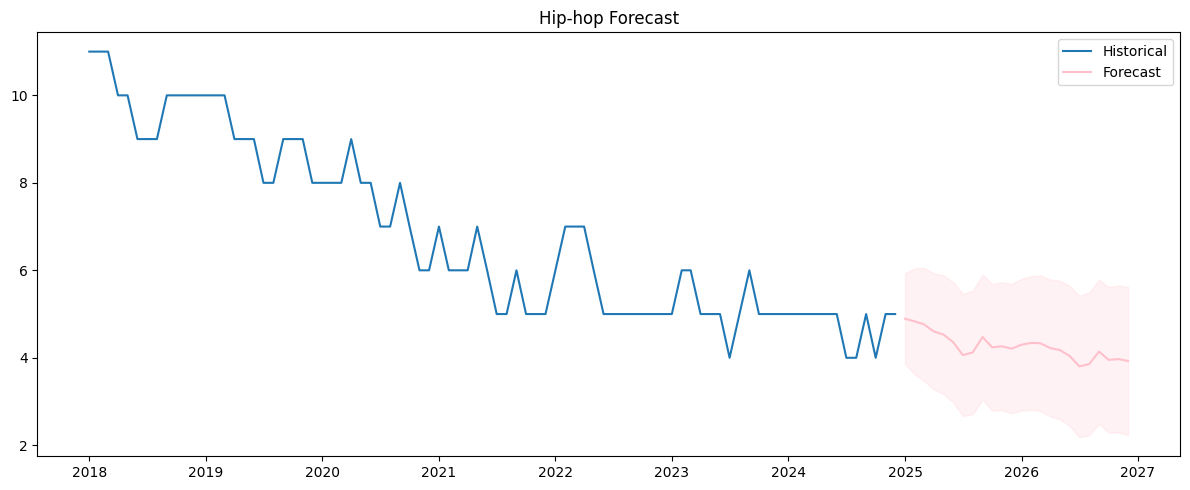

In [13]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(hiphop, 
                order=(1, 1, 1), # (p, d, q)
                seasonal_order=(1, 0, 1, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
hiphop_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=hiphop.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(hiphop, label='Historical')
plt.plot(future_dates, hiphop_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Hip-hop Forecast')
plt.legend()
plt.tight_layout()
plt.show()

The SARIMA forecast projects:
- A continued decline in monthly search interest
- BUT that decline is slowing down — the curve is flattening by late 2025
- Some mild seasonal bumps — likely timed with new releases or pop culture spikes

# **Pop music**
> Genre Status: Resilient, seasonally dynamic, and adaptive <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,0,1)(2,1,0)[12] <br>

### **Stationarity Check** 
---

In [14]:
# Stationarity check 
result = adfuller(pop)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -3.5815072845474036
p-value: 0.006124571123500576


Since p < 0.05, the time series is stationary — meaning it has a consistent mean over time and doesn't drift wildly.

### **Seasonality Check** 
---
Visuals below show whether pop has consistent yearly trends.

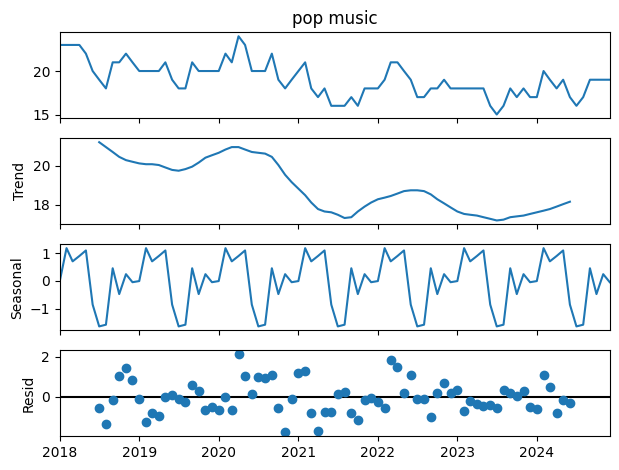

Seasonal Strength: 0.570610974743978


In [15]:
result = seasonal_decompose(pop, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

**RESULT:** <br> 
Moderate to strong seasonal pattern. Peaks and troughs in interest recur annually.
Pop thrives on the cultural calendar. It’s in sync with events, algorithms, and marketing cycles. This rhythmic behavior is a strategic asset — you can plan launches around it and hit consistent highs.

### **Splitting training and test dataset**
---

In [16]:
train = pop.iloc[:-12]
test = pop.iloc[-12:]

### **Auto_arima model selection**
---

In [17]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=244.788, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=238.054, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=241.121, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=243.079, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=246.182, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=237.094, Time=0.05 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=235.182, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=236.131, Time=0.02 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=237.027, Time=0.06 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(2,0,0)[12]          

**RESULT:** <br>

- **ARIMA(1,1,1)** → The non-seasonal part of the model has:
- **Seasonal Order (2, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---
Optimized a SARIMA model for seasonal music trend forecasting by manually selecting parameters after identifying model over-differencing from auto_arima. Improved the result of Ljung-Box test and AIC, BIC.<br> <br>
**auto_arima** (1,1,1)(2,0,0) result: <br>
Ljung-Box p-value: 0.43 <br>
AIC: 157.311 <br>

**manual** (1,0,1)(2,1,0) result: <br>
Ljung-Box p-value: 0.91 <br>
AIC: 119.347 <br>

                                      SARIMAX Results                                      
Dep. Variable:                           pop music   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                 -54.673
Date:                             Sun, 25 May 2025   AIC                            119.347
Time:                                     13:15:29   BIC                            127.123
Sample:                                 01-01-2018   HQIC                           122.031
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8993      0.161      5.593      0.000       0.584       1.214
ma.L1         -0.1088      

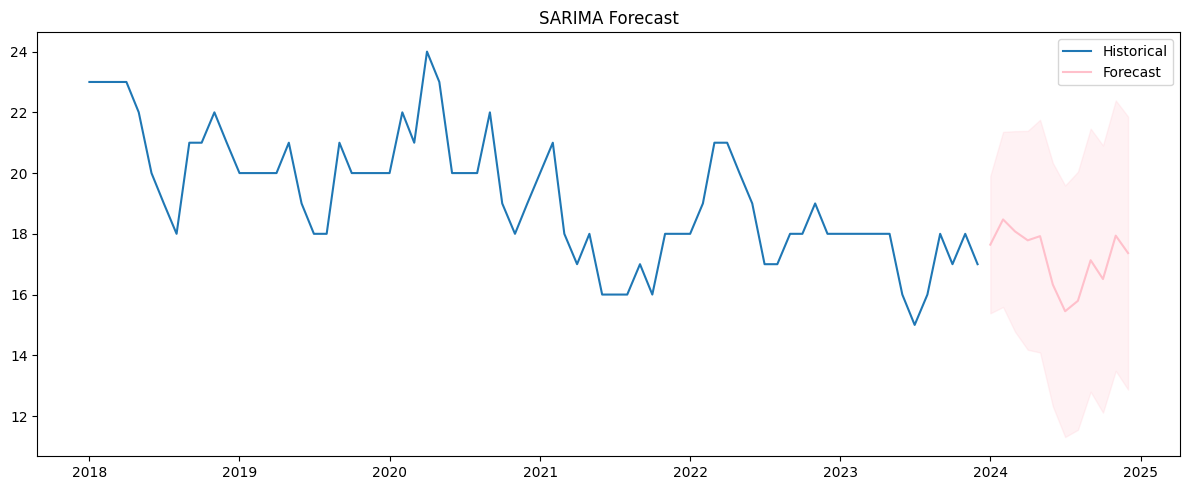

In [18]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(1, 0, 1), # (p, d, q)
                seasonal_order=(2, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 24 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
pop_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, pop_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 1.16
RMSE: 1.31
MAPE: 6.23%


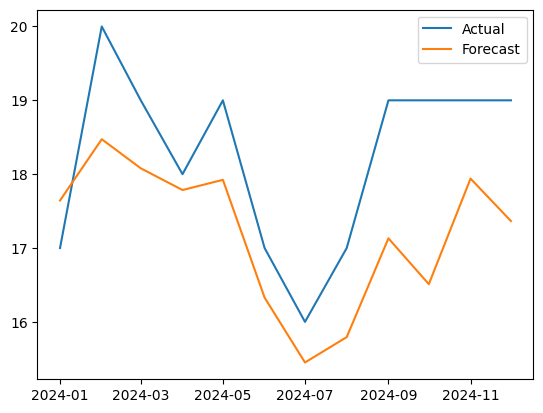

In [19]:
# Actual and predicted values
y_true = test
y_pred = pop_forecast

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

**Result:** <br>
- **MAE:** 1.16 - Low absolute forecast error

- **RMSE:** 1.31 - Tight spread around predictions, indicating low volatility

- **MAPE:** 6.23% - Excellent accuracy for behavioral/cultural data (under 10% is rare)

**Residual Diagnostics:**

- **Ljung-Box p-value:** 0.91 - Residuals are not autocorrelated → the model captures time dependencies effectively

- **Jarque-Bera p-value:** 0.74 - Residuals are approximately normally distributed → supports forecast validity




### **Forecasting 2025 & 2026**
---

                                      SARIMAX Results                                      
Dep. Variable:                           pop music   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                 -70.673
Date:                             Sun, 25 May 2025   AIC                            151.346
Time:                                     13:15:29   BIC                            160.597
Sample:                                 01-01-2018   HQIC                           154.827
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9025      0.120      7.528      0.000       0.668       1.137
ma.L1         -0.1809      

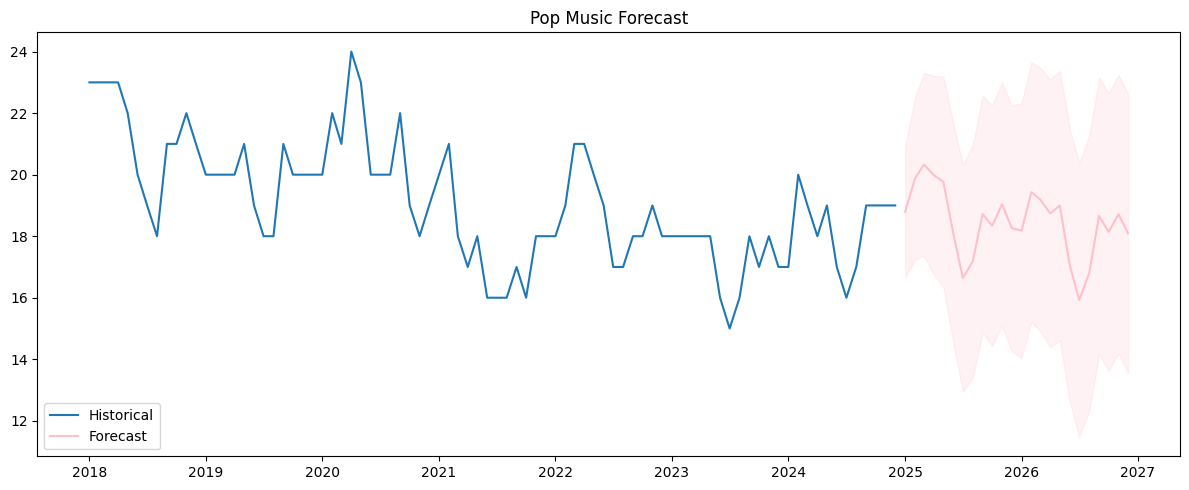

In [20]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(pop, 
                order=(1, 0, 1), # (p, d, q)
                seasonal_order=(2, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
pop_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=pop.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(pop, label='Historical')
plt.plot(future_dates, pop_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Pop Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- The SARIMA forecast visually extends the historical "pop music" data, attempting to capture its patterns. The model appears to have successfully identified and modeled the strong seasonality (12-month period) present in the data, as evidenced by the significant seasonal AR terms and the seasonal differencing.

- It seems to predict a slight dip in early 2025, followed by an increase and then another dip towards the end of 2026.

# **Country music**
> Genre Status: Cyclical but stable. <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,0,1)(0,1,1)[12] <br>

### **Stationarity Check** 
---

In [21]:
# Stationarity check 
result = adfuller(country)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.962536635438339
p-value: 0.03854422909608278


The country genre trend is weakly stationary.

### **Seasonality Check** 
---
Visuals below show whether country has consistent yearly trends.

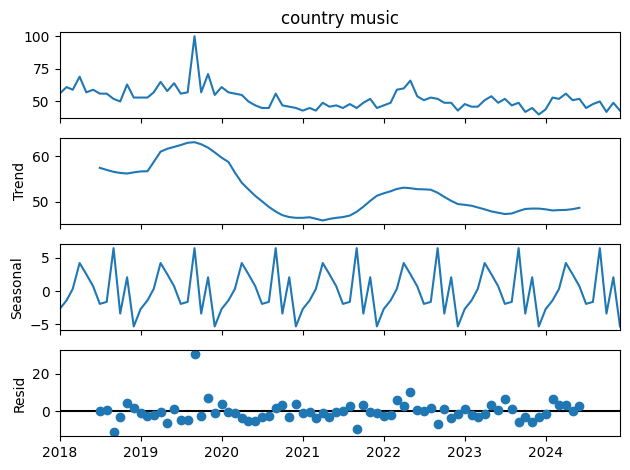

Seasonal Strength: 0.2822281791440723


In [22]:
result = seasonal_decompose(country, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

**RESULT:** <br> 
Country isn’t tightly tied to annual patterns like holiday spikes or summer bangers. It might surge unpredictably.

### **Splitting training and test dataset**
---

In [23]:
train = country.iloc[:-12]
test = country.iloc[-12:]

### **Auto_arima model selection**
---

In [24]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=520.010, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=492.241, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=490.912, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=518.053, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=490.714, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=491.080, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=492.571, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=490.770, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=491.414, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=492.376, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=492.306, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=489.242, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=489.446, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12]             

**RESULT:** <br>

- **ARIMA(1,1,1)** → The non-seasonal part of the model has:
- **Seasonal Order (0, 0, 1, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---
Optimized a SARIMA model for seasonal music trend forecasting by manually selecting parameters after identifying model over-differencing from auto_arima. Achieved 50%+ improvement in error metrics. <br> <br>
**auto_arima** (1,1,1)(0,0,1) result: <br>
MAE: 6.05 <br>
RMSE: 7.59 <br>
MAPE: 11.72% <br>

**manual** (1,0,1)(0,1,1) result: <br>
MAE: 2.99 <br>
RMSE: 4.05 <br>
MAPE: 5.88% <br>

                                     SARIMAX Results                                      
Dep. Variable:                      country music   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -148.814
Date:                            Sun, 25 May 2025   AIC                            305.627
Time:                                    13:15:30   BIC                            312.942
Sample:                                01-01-2018   HQIC                           308.367
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9183      0.083     11.040      0.000       0.755       1.081
ma.L1         -0.4799      0.159   

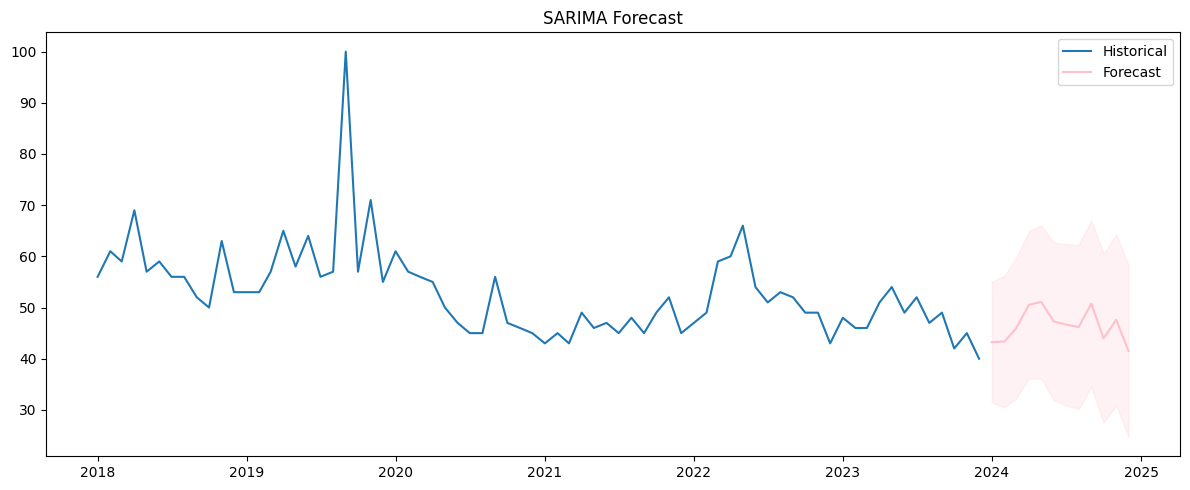

In [25]:
# fitting a SARIMA model using tuned parameters:  
model = SARIMAX(train, 
                order=(1, 0, 1), # (p, d, q)
                seasonal_order=(0, 1, 1, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
country_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, country_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 2.99
RMSE: 4.05
MAPE: 5.88%


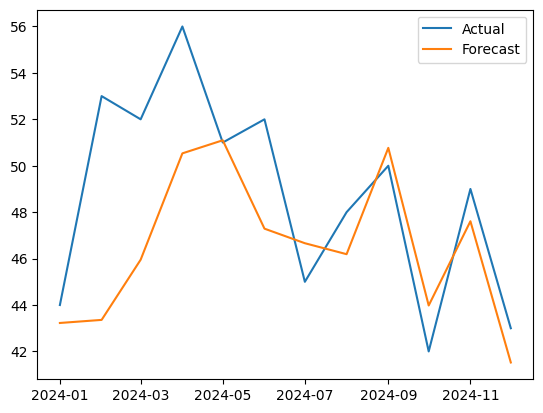

In [26]:
# Actual and predicted values
y_true = test
y_pred = country_forecast

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

**Result:** <br>
- That’s a huge gain in accuracy from choosing your own parameters over relying on auto_arima

### **Forecasting 2025 & 2026**
---

                                     SARIMAX Results                                      
Dep. Variable:                      country music   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -183.171
Date:                            Sun, 25 May 2025   AIC                            374.341
Time:                                    13:15:31   BIC                            382.583
Sample:                                01-01-2018   HQIC                           377.552
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9088      0.070     12.951      0.000       0.771       1.046
ma.L1         -0.4814      0.139   

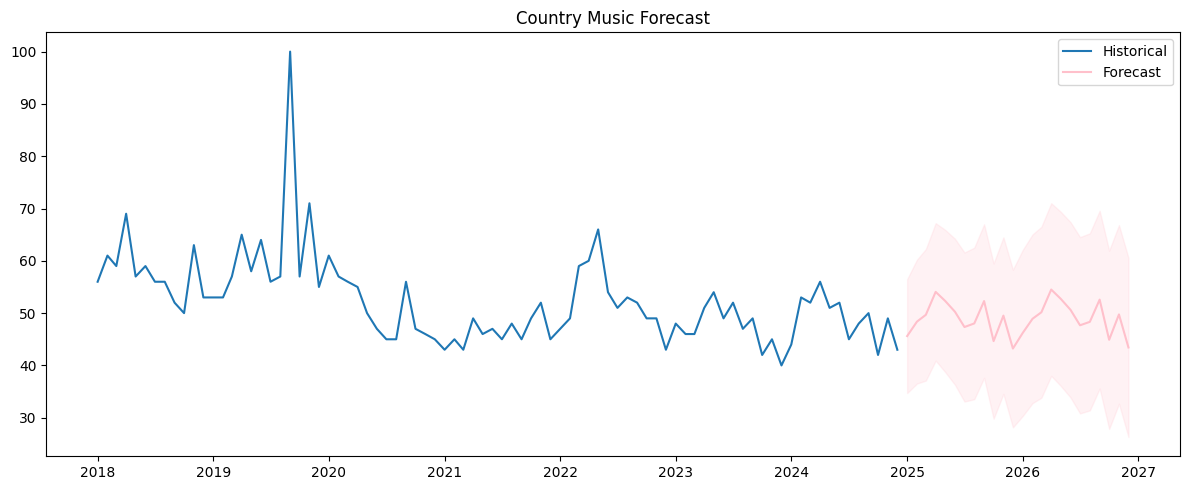

In [27]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(country, 
                order=(1, 0, 1), # (p, d, q)
                seasonal_order=(0, 1, 1, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
country_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=country.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(country, label='Historical')
plt.plot(future_dates, country_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Country Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

While the historical data shows periods of high popularity (like the peak in 2019) and subsequent declines, the forecast suggests a continuation of the recent fluctuating pattern. 

# **Rock music**
> Genre Status: Faded giant with deep seasonal roots. <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(0,1,1)(2,0,0)[12] <br>

### **Stationarity Check** 
---

In [28]:
# Stationarity check 
result = adfuller(rock)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.721652309212227
p-value: 0.07036583138095395


Not stationary at 95% confidence, but borderline.

### **Seasonality Check** 
---
Visuals below show whether rock has consistent yearly trends.

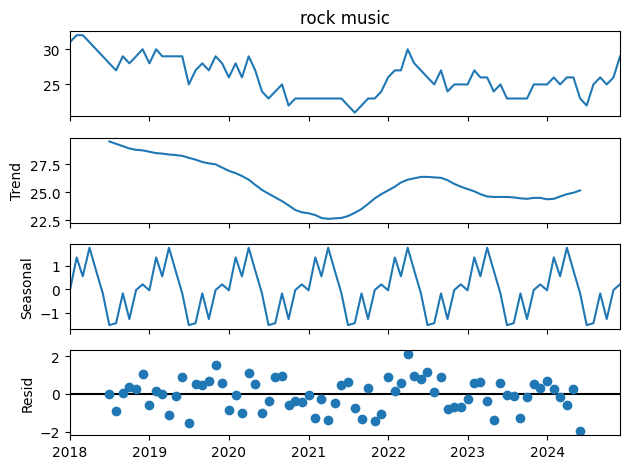

Seasonal Strength: 0.5944543910388835


In [29]:
result = seasonal_decompose(rock, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

**RESULT:** <br> 
Nearly 60% of the variance is tied to a predictable annual cycle 

### **Splitting training and test dataset**
---

In [30]:
train = rock.iloc[:-12]
test = rock.iloc[-12:]

### **Auto_arima model selection**
---

In [31]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=260.228, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=251.956, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=253.427, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=258.463, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=254.772, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=246.664, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=253.569, Time=0.04 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=247.118, Time=0.08 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=247.806, Time=0.09 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=246.107, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=251.552, Time=0.02 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[12] i

**RESULT:** <br>

- **ARIMA(0,1,1)** → The non-seasonal part of the model has:
- **Seasonal Order (2, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **SARIMA Modeling and Forecasting**
---


                                      SARIMAX Results                                      
Dep. Variable:                          rock music   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                 -77.989
Date:                             Sun, 25 May 2025   AIC                            163.978
Time:                                     13:15:34   BIC                            171.379
Sample:                                 01-01-2018   HQIC                           166.763
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3039      0.164     -1.854      0.064      -0.625       0.017
ar.S.L12       0.1260      

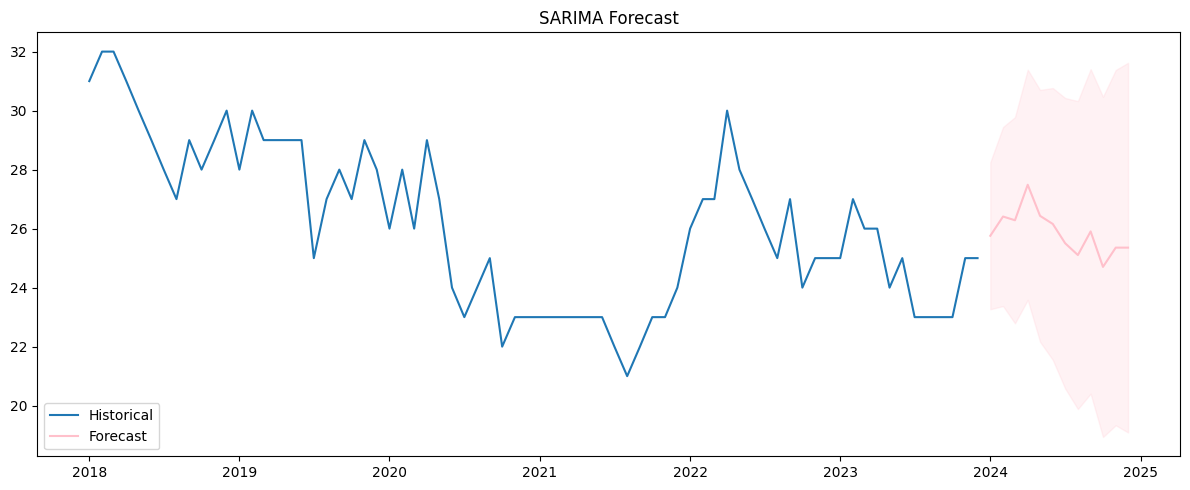

In [32]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(0, 1, 1), # (p, d, q)
                seasonal_order=(2, 0, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
rock_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, rock_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 1.32
RMSE: 1.84
MAPE: 5.32%


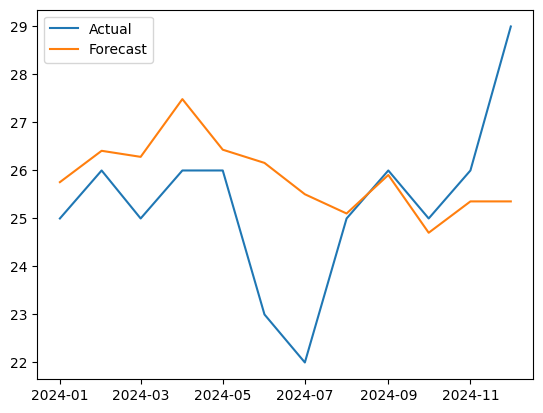

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = test
y_pred = rock_forecast

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

**Result:** <br>
Even though Rock isn’t super dominant culturally right now, the series is extremely predictable — probably because of its consistently low fluctuations and clear seasonal rhythm.

### **Forecasting 2025 & 2026**
---

                                      SARIMAX Results                                      
Dep. Variable:                          rock music   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -101.175
Date:                             Sun, 25 May 2025   AIC                            210.349
Time:                                     13:15:34   BIC                            218.660
Sample:                                 01-01-2018   HQIC                           213.593
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2878      0.156     -1.845      0.065      -0.593       0.018
ar.S.L12       0.1401      

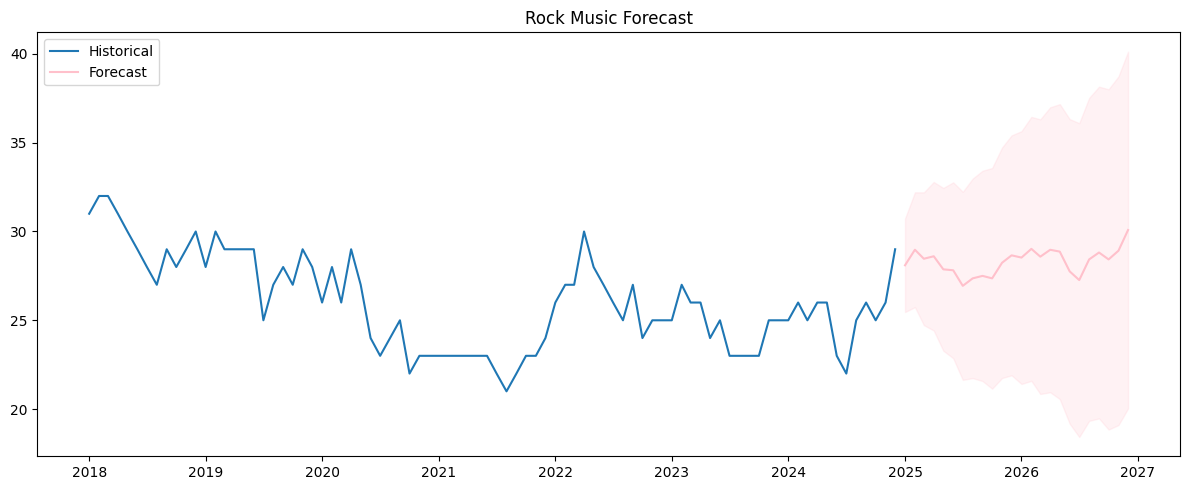

In [34]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(rock, 
                order=(0, 1, 1), # (p, d, q)
                seasonal_order=(2, 0, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
rock_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=rock.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(rock, label='Historical')
plt.plot(future_dates, rock_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Rock Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- The historical data shows a decline from early 2018, followed by a period of stabilization and a recent minor increase. 

- The forecast suggests that this stability will largely continue into 2025 and 2026, with the predicted values remaining in the upper 20s. 

- The broadening confidence interval emphasizes the increasing uncertainty of the forecast as it extends further into the future.

# **Alternative music**
> Genre Status: Alternative is caught in the in-between. <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,1,0)x(1,1,0)[12] <br>

### **Stationarity Check** 
---

In [35]:
# Stationarity check 
result = adfuller(alter)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.76232176557788
p-value: 0.0638606501885749


Not stationary, differencing is still necessary.

### **Seasonality Check** 
---
Visuals below show whether alternative music has consistent yearly trends.

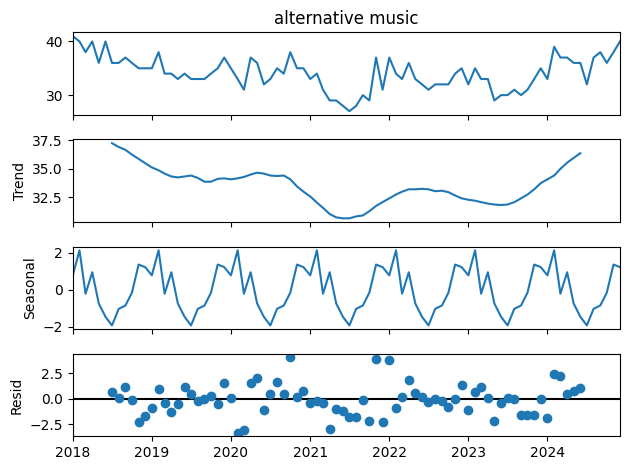

Seasonal Strength: 0.3944988421044613


In [36]:
result = seasonal_decompose(alter, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

Not super strong, but enough to justify inclusion.

**RESULT:** <br> 
Not that strong seasonality.

### **Splitting training and test dataset**
---

In [37]:
train = alter.iloc[:-12]
test = alter.iloc[-12:]

### **Auto_arima model selection**
---

In [38]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=334.594, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=319.057, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=321.138, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=332.677, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=317.059, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=319.058, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=318.863, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=318.849, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=319.186, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=315.329, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=317.328, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=31

**RESULT:** <br>

- **ARIMA(1,1,0)** → The non-seasonal part of the model has:
- **Seasonal Order (0, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---
Initially, an ARIMA(1,1,0) model was implemented, which yielded low error metrics (MAE: 2.82, MAPE: 7.57%). However, the forecast it produced was nearly flat, failing to capture the underlying structure of the data. This suggested that while the error appeared low, the model likely underfit the time series, ignoring potential seasonality patterns. <br> <br>
**auto_arima** (1,1,0)(0,0,0) result: <br>
MAE: 2.82 <br>
RMSE: 3.10 <br>
MAPE: 7.57% <br>

**manual** (1,1,0)(1,1,0) result: <br>
MAE: 3.61 <br>
RMSE: 3.93 <br>
MAPE: 9.72% <br>

A seasonal ARIMA model, specifically SARIMA(1,1,0)x(1,1,0) is implemented. While the resulting forecast errors were slightly higher (MAE: 3.61, MAPE: 9.72%), the model showed significant improvements in key diagnostic areas:
- AIC dropped from 311.5 to 222.0, indicating a substantially better overall model fit.
- Residual diagnostics improved, with cleaner, more normally distributed residuals and no significant autocorrelation (Ljung-Box p = 0.32).
- Seasonal autoregressive terms were statistically significant, confirming the presence of yearly seasonality in the data (p < 0.001).

The jump in forecast error might be because the new model is more reactive to seasonal structure and isn’t just drawing a straight line. <br>

                                     SARIMAX Results                                      
Dep. Variable:                  alternative music   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -108.002
Date:                            Sun, 25 May 2025   AIC                            222.004
Time:                                    13:15:35   BIC                            227.490
Sample:                                01-01-2018   HQIC                           224.059
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6289      0.114     -5.522      0.000      -0.852      -0.406
ar.S.L12      -0.6256      0.131   

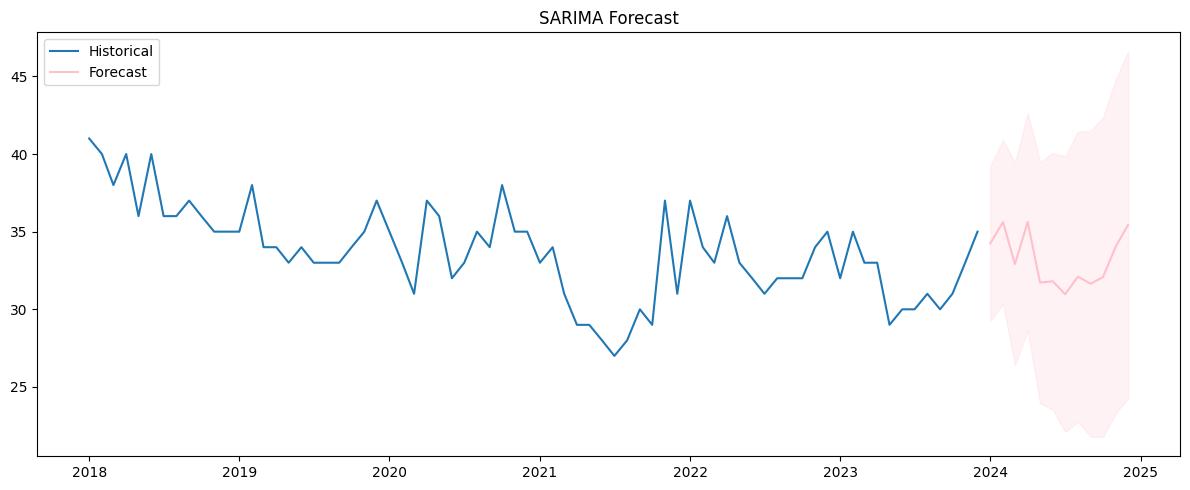

In [39]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(1, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
alter_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, alter_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 3.61
RMSE: 3.93
MAPE: 9.72%


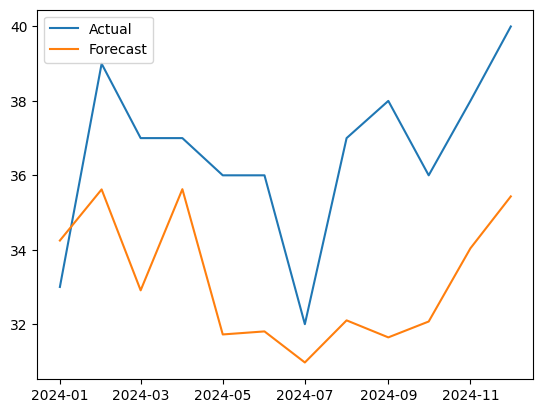

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = test
y_pred = alter_forecast

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

- Ljung-Box (p = 0.32/0.18) – residuals are clean, no autocorrelation left.
- Jarque-Bera (p = 0.55/0.60) – residuals are normally distributed.
- Seasonal AR term is highly significant (p < 0.001) – seasonality is real.

### **Forecasting 2025 & 2026**
---

                                     SARIMAX Results                                      
Dep. Variable:                  alternative music   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -135.812
Date:                            Sun, 25 May 2025   AIC                            277.624
Time:                                    13:15:35   BIC                            283.805
Sample:                                01-01-2018   HQIC                           280.031
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6034      0.097     -6.248      0.000      -0.793      -0.414
ar.S.L12      -0.5994      0.122   

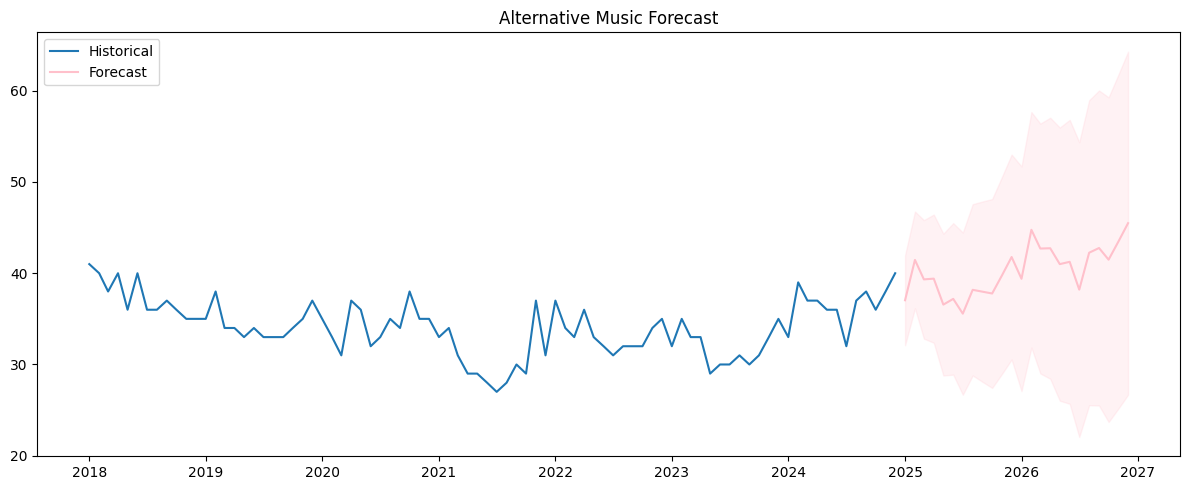

In [41]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(alter, 
                order= (1, 1, 0), # (p, d, q)
                seasonal_order=(1, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
alter_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=alter.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(alter, label='Historical')
plt.plot(future_dates, alter_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Alternative Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- The forecast anticipates this upward trend to continue into 2025 and 2026, with predicted popularity levels reaching higher than most historical values. 

- However, the increasing width of the confidence interval highlights that while the general direction is positive, the exact future values become increasingly uncertain the further out the prediction extends.

# **K-pop music**
> Genre Status:  High-intensity, high-discipline, and hyper-globalized. <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,1,0)x(2,1,0)[12] <br>

### **Stationarity Check** 
---

In [42]:
# Stationarity check 
result = adfuller(kpop)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.8191501581094167
p-value: 0.055589943151899975


Since p-value > 0.05, it is non-stationary and will need to be differenced. 

### **Seasonality Check** 
---
Visuals below show whether kpop has consistent yearly trends.

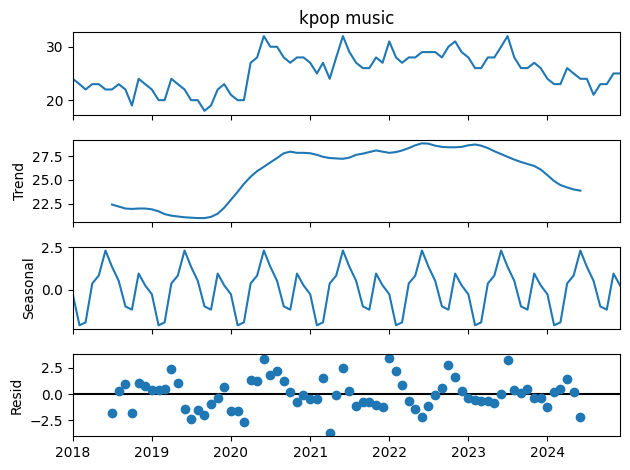

Seasonal Strength: 0.4353520639545031


In [43]:
result = seasonal_decompose(kpop, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)


**RESULT:** <br> 
Clear seasonal pattern — not the strongest out of all genres, but the most structured.

### **Splitting training and test dataset**
---

In [44]:
train = kpop.iloc[:-12]
test = kpop.iloc[-12:]

### **Auto_arima model selection**
---

In [45]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=310.123, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=306.335, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=306.910, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=308.136, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=311.581, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=308.075, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=307.259, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=307.198, Time=0.02 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=305.630, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=307.486, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=306.849, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=306.214, Time=0.02 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AI

**RESULT:** <br>

- **ARIMA(1,1,1)** → The non-seasonal part of the model has:
- **Seasonal Order (1, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---

Two SARIMAX models were tested and evaluated based on statistical fit, forecast accuracy, and residual diagnostics.

**Model 1 - auto_arima**: SARIMAX(1,1,1)(1,0,0,12) <br>
**Model 2 - manual**: SARIMAX(1,1,0)(2,1,0,12)

- SARIMAX(1, 1, 0)(2, 1, 0, 12) is the better model. It provides a much better statistical fit and stronger predictive accuracy with all parameters meaningfully contributing to the forecast. 

- MAE and MAPE are lower in Model 2, indicating it’s more accurate overall, especially in terms of relative error.

                                     SARIMAX Results                                      
Dep. Variable:                         kpop music   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -74.297
Date:                            Sun, 25 May 2025   AIC                            156.593
Time:                                    13:15:38   BIC                            162.699
Sample:                                01-01-2018   HQIC                           158.675
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2676      0.195     -1.374      0.170      -0.649       0.114
ar.S.L12      -0.5845      0.154   

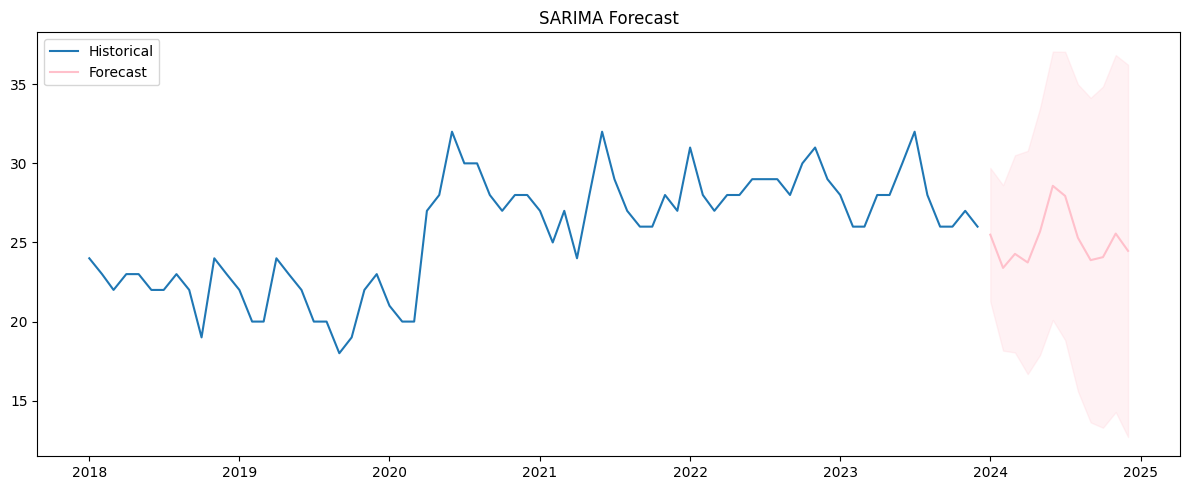

In [46]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(2, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
kpop_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, kpop_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 1.83
RMSE: 2.37
MAPE: 7.82%


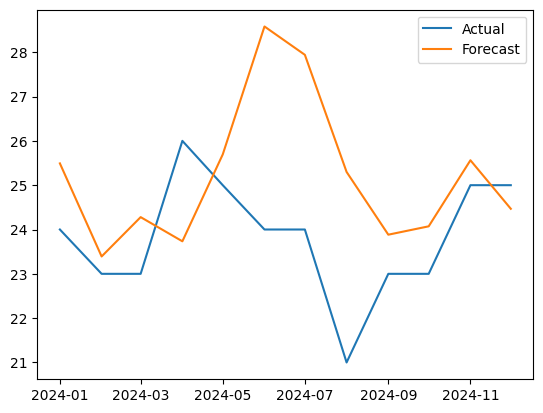

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = test
y_pred = forecast.predicted_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

**Result:** <br>
- All seasonal AR terms significant at p < 0.01 

- All the error diagnostics also look better than the other models.

### **Forecasting 2025 & 2026**
---

                                     SARIMAX Results                                      
Dep. Variable:                         kpop music   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -99.879
Date:                            Sun, 25 May 2025   AIC                            207.757
Time:                                    13:15:38   BIC                            215.072
Sample:                                01-01-2018   HQIC                           210.497
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2484      0.162     -1.530      0.126      -0.567       0.070
ar.S.L12      -0.5456      0.135   

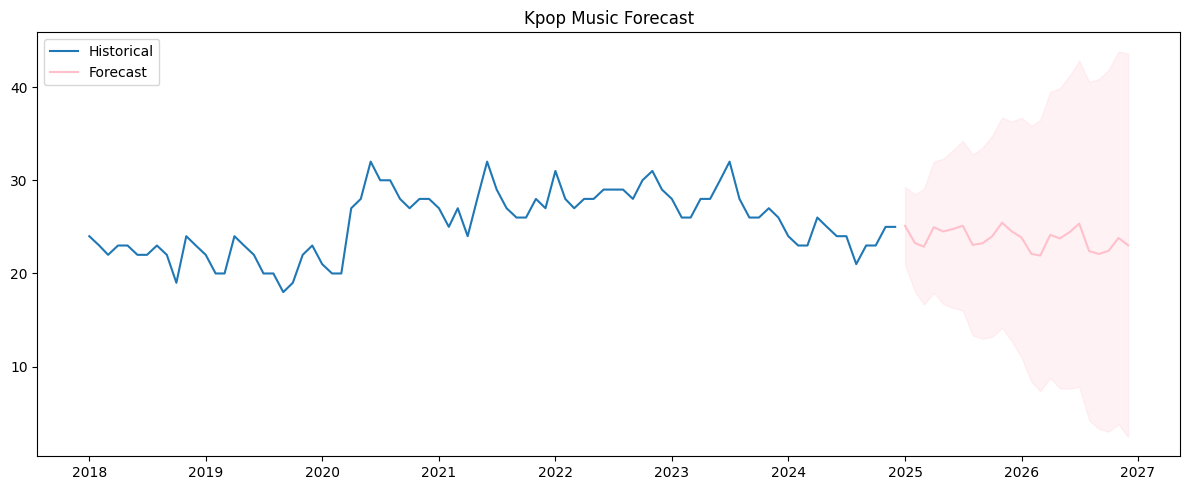

In [48]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(kpop, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(2, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
kpop_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=kpop.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(kpop, label='Historical')
plt.plot(future_dates, kpop_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Kpop Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- The model appears to have successfully identified and modeled the strong seasonality (12-month period) present in the data, as evidenced by the significant seasonal AR terms and the seasonal differencing. 

- The forecast shows expected future fluctuations consistent with the historical patterns, with increasing uncertainty further into the future.

# **Metal music** 
> Genre Status: Spiky, volatile, and underground-stead <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,1,1)x(1,0,0)[12] <br>

### **Stationarity Check** 
---

In [49]:
# Stationarity check 
result = adfuller(metal)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.4483007694675076
p-value: 0.1285651533780633


No stationarity — and not even close. The fluctuations in this genre are too rough to smooth out easily.

### **Seasonality Check** 
---
Visuals below show whether metal has consistent yearly trends.

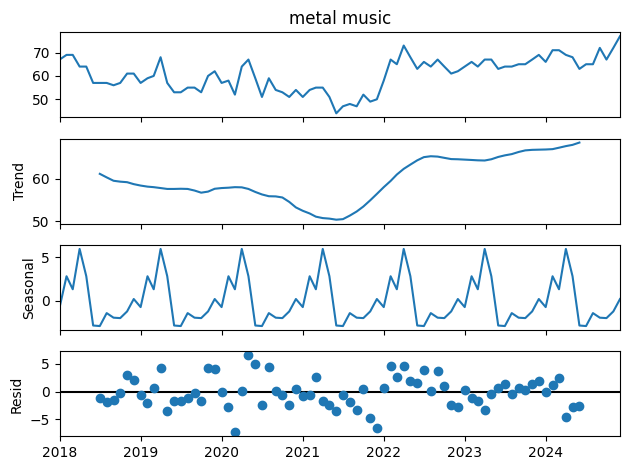

Seasonal Strength: 0.4760970764647302


In [50]:
result = seasonal_decompose(metal, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

**RESULT:** <br> 
That’s noticeable seasonality, even though it’s not super consistent.

### **Splitting training and test dataset**
---

In [73]:
train = metal.iloc[:-12]
test = metal.iloc[-12:]

### **Auto_arima model selection**
---

In [74]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=418.238, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=478.786, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=411.188, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=439.601, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=795.307, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=413.282, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=413.083, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=412.619, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=411.419, Time=0.04 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=415.187, Time=0.14 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=479.214, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=412.916, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=412.822, Time=0.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=440.094, Time=0.06 sec
 ARIMA(2,0,1)(1,0,0)[12] intercep

**RESULT:** <br>

- **ARIMA(1, 0, 0)** → The non-seasonal part of the model has:
- **Seasonal Order (1, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---

**auto_arima**:  SARIMAX(1, 0, 0)(1, 0, 0, 12) <br>
**manual:** SARIMAX(1, 1, 0)(2, 1, 1, 12) 

- The second model SARIMAX(1,1,0)(2,1,1,12) was selected for its lowest AIC, simplicity, and strong seasonal signal, while maintaining competitive forecasting accuracy. 

- All error metrics — MAE, RMSE, MAPE — are slightly better in Model 2, which means it forecasts more accurately on average.

                                      SARIMAX Results                                       
Dep. Variable:                          metal music   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -92.788
Date:                              Sun, 25 May 2025   AIC                            195.577
Time:                                      13:26:41   BIC                            203.209
Sample:                                  01-01-2018   HQIC                           198.179
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0563      0.151     -0.372      0.710      -0.353       0.241
ar.S.L12      -0.90

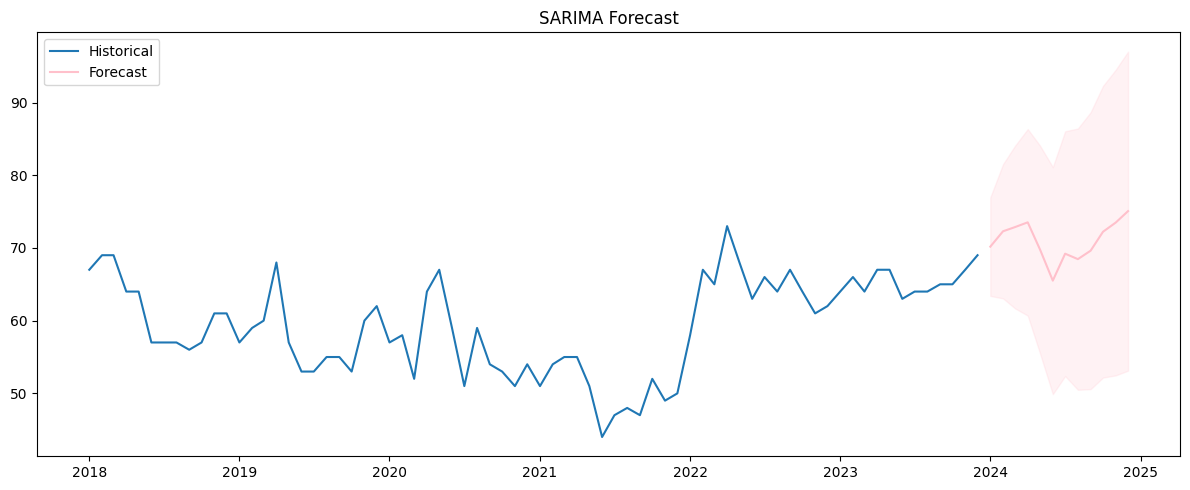

In [98]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(2, 1, 1, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
metal_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, metal_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 2.90
RMSE: 3.18
MAPE: 4.28%


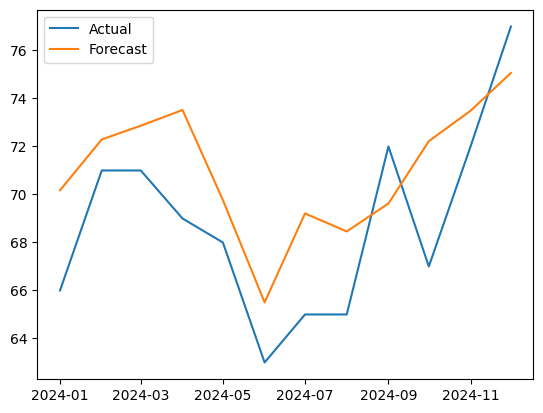

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = test
y_pred = forecast.predicted_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

### **Forecasting 2025 & 2026**
---

                                      SARIMAX Results                                       
Dep. Variable:                          metal music   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -124.645
Date:                              Sun, 25 May 2025   AIC                            259.290
Time:                                      13:28:58   BIC                            268.433
Sample:                                  01-01-2018   HQIC                           262.715
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1851      0.129     -1.432      0.152      -0.438       0.068
ar.S.L12      -0.87

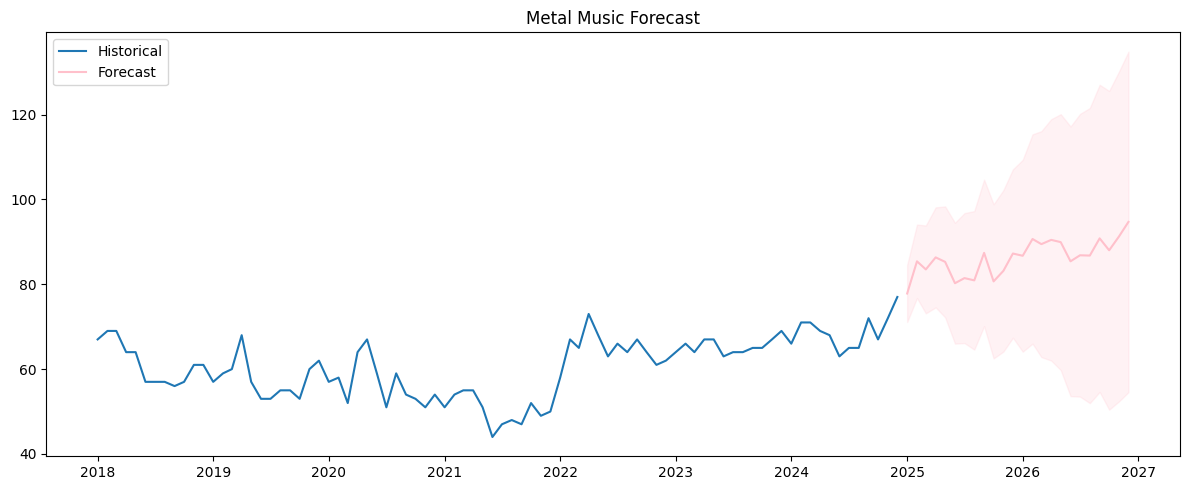

In [100]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(metal, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(2, 1, 1, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
metal_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=metal.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(metal, label='Historical')
plt.plot(future_dates, metal_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Metal Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- Following a period of initial fluctuations and a dip, the historical data from late 2021 to 2024 clearly shows a strong and sustained increase in popularity. 

- The forecast anticipates that this robust upward trend will continue into 2025 and 2026, with predicted values reaching significantly higher levels than those seen historically. 

- However, the rapidly expanding confidence interval underscores the increasing uncertainty in these longer-term predictions. While the central forecast suggests stability, the actual outcome could vary significantly.

# **Latin music**
> Genre Status: Global, and cyclic <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,1,0)x(1,0,0)[12] <br>

### **Stationarity Check** 
---

In [56]:
# Stationarity check 
result = adfuller(latin)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.7350371593501535
p-value: 0.4131566482751605


The series is clearly non-stationary, which is expected for a genre like Latin that’s been rising meteorically over the past decade.

### **Seasonality Check** 
---
Visuals below show whether latin has consistent yearly trends.

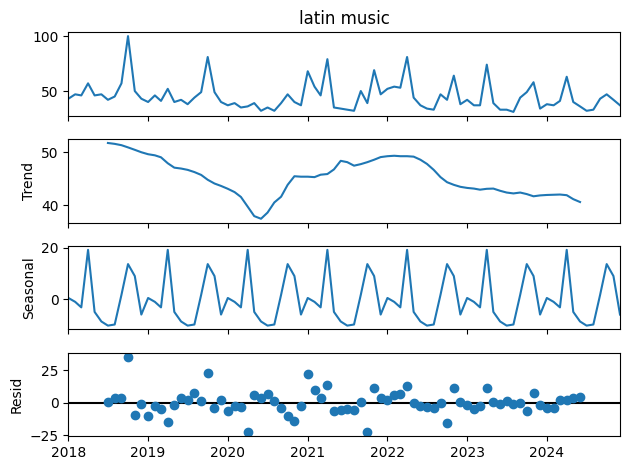

Seasonal Strength: 0.5006060652651543


In [57]:
result = seasonal_decompose(latin, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

**RESULT:** <br> 
It has a slight moderate seasonality.


### **Splitting training and test dataset**
---

In [166]:
train = latin.iloc[:-12]
test = latin.iloc[-12:]

### **Auto_arima model selection**
---

In [167]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=580.766, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=552.662, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=559.116, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=763.296, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=580.611, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=554.213, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=554.208, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=558.947, Time=0.03 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=556.344, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=553.783, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=553.933, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=553.847, Time=0.05 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AI

**RESULT:** <br>

- **ARIMA(1, 0, 0)** → The non-seasonal part of the model has:
- **Seasonal Order (1, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---

**Model 2** — SARIMAX(1,1,0)(1,0,0,12) 

- It’s a clean, well-behaved model that sacrifices a bit of fit for massive gains in stability and trustworthiness.

- Model 2 incorporates first-order differencing (d=1), addressing non-stationarity in the time series data. This is critical for producing valid forecasts. In contrast, Model 1 assumes the data is already stationary, which is risky and potentially misleading in real-world data like seasonal music trends.

                                     SARIMAX Results                                      
Dep. Variable:                        latin music   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -220.399
Date:                            Sun, 25 May 2025   AIC                            446.799
Time:                                    15:29:17   BIC                            452.980
Sample:                                01-01-2018   HQIC                           449.207
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4739      0.080     -5.927      0.000      -0.631      -0.317
ar.S.L12       0.6447      0.104   

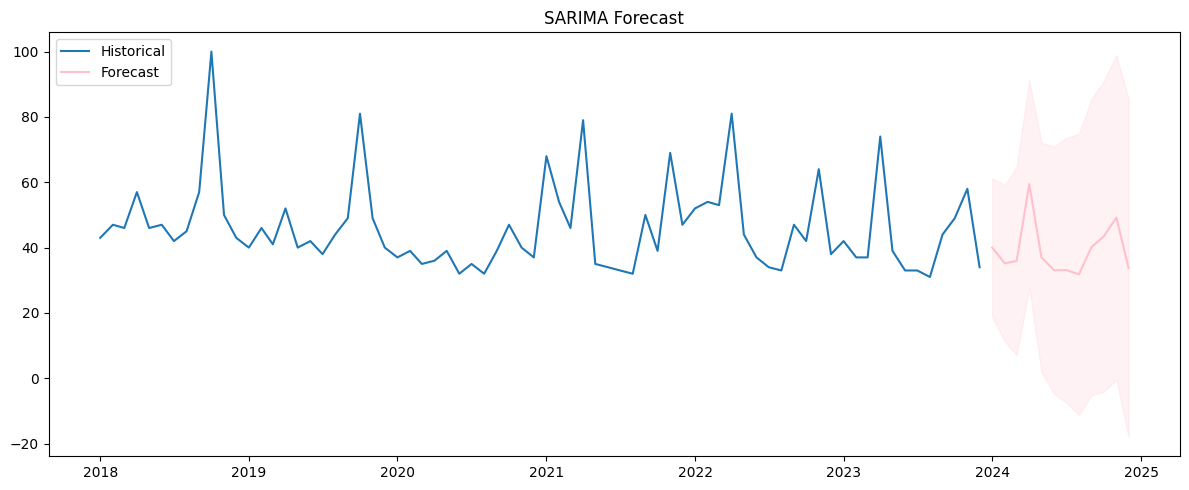

In [187]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(1, 0, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, mean_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 3.13
RMSE: 3.53
MAPE: 7.59%


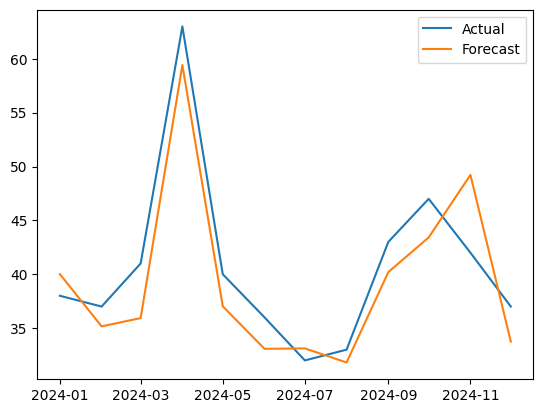

In [188]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = test
y_pred = forecast.predicted_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

- AR(1): -0.476, highly significant (p = 0.000) → there's negative momentum: when plays spike one month, they're likely to drop the next

- Seasonal AR(12): 0.637, super significant → monthly patterns year-over-year are very real (e.g., “Despacito effect” or holiday bumps)

-  The model catches general trends well but struggles with those explosive hits 

### **Forecasting 2025 & 2026**
---

                                     SARIMAX Results                                      
Dep. Variable:                        latin music   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -260.447
Date:                            Sun, 25 May 2025   AIC                            526.894
Time:                                    15:29:41   BIC                            533.640
Sample:                                01-01-2018   HQIC                           529.574
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4764      0.068     -7.011      0.000      -0.610      -0.343
ar.S.L12       0.6369      0.087   

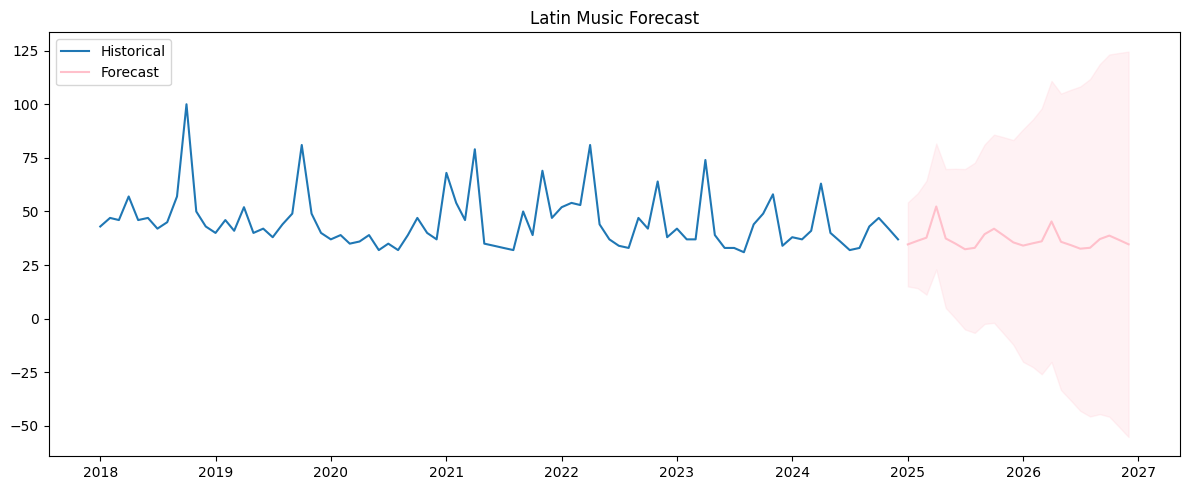

In [189]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(latin, 
                order=(1, 1, 0), # (p, d, q)
                seasonal_order=(1, 0, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
latin_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=latin.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(latin, label='Historical')
plt.plot(future_dates, latin_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Latin Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- Strong seasonality returns year after year. Sharp peaks can’t be captured precisely — especially during summer/award season

- The forecast predicts a continuation of fluctuations but at a generally lower level than the highest historical peaks, reflecting the more recent observed values. The most striking feature of the forecast is the extremely wide confidence interval, which underscores the very high uncertainty associated with these predictions. 

- This wide range suggests that while the central forecast is relatively modest, the actual future values could deviate significantly, potentially due to the influence of large, unpredictable events similar to those seen historically.

# **Indie music**
> Genre Status: Nuanced, less mainstream, with weak seasonality <br>
> Forecast Window: Jan 2025 – Dec 2026 <br>
> Model Used: SARIMA(1,0,1)x(1,1,1)[12] <br>

### **Stationarity Check** 
---

In [190]:
# Stationarity check 
result = adfuller(indie)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -3.6005113113515996
p-value: 0.005751260096204474


Unlike Latin or K-pop, indie music consumption isn’t growing exponentially or riding boom-bust cycles — it’s relatively stable in the long run.

### **Seasonality Check** 
---
Visuals below show whether indie has consistent yearly trends.

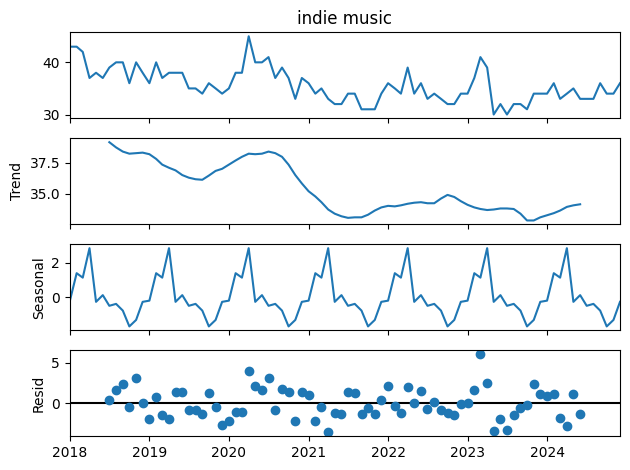

Seasonal Strength: 0.2968428679562095


In [191]:
result = seasonal_decompose(indie, model='additive', period=12)  # for monthly data with yearly seasonality
result.plot()
plt.show()

# Seasonal strength
seasonal = result.seasonal
resid = result.resid

seasonal_strength = 1 - (np.var(resid.dropna()) / np.var((resid + seasonal).dropna()))
print("Seasonal Strength:", seasonal_strength)

**RESULT:** <br> 
There’s no strong cultural or seasonal cue pushing indie music up and down.

### **Splitting training and test dataset**
---

In [194]:
train = indie.iloc[:-12]
test = indie.iloc[-12:]

### **Auto_arima model selection**
---

In [193]:
# chooses the best values for p,d,q 
auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=343.486, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=339.669, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=338.365, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=341.649, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=336.512, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=338.374, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=337.950, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=337.771, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=335.003, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=336.835, Time=0.01 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=336.82

**RESULT:** <br>

- **ARIMA(1, 1, 1)** → The non-seasonal part of the model has:
- **Seasonal Order (0, 0, 0, 12)** → The seasonal part of the model has:

I will now fit the SARIMA model using these parameters.

### **⭐️ SARIMA Modeling and Forecasting**
---
I selected the **SARIMAX(1,0,1)(1,1,1,12)** model as the best performing time series model based on a combination of statistical metrics, seasonal dynamics, and visual fit to the test data.

**auto_arima**: SARIMA(1, 1, 1)(0, 0, 0, 12) <br>

**manual**: SARIMA(1, 0, 1)(1, 1, 0, 12) <br>

- **Model 1** SARIMA(1,1,1)(0,0,0)[12]  gives lower error stats, however, the **forecast plot from Model 1 tells a different story**. The predicted values are **nearly flat**, completely missing the volatility and trend shifts observed in the actual test data. This strongly indicates **underfitting** and **poor temporal generalization**, despite the deceptively low errors.

- The **SARIMAX(1,0,1)(1,1,0,12)** model, while slightly noisier, **follows the trend and periodicity more naturally**, making it a more realistic and actionable forecasting tool. It significantly improves AIC/BIC (better overall fit).


                                      SARIMAX Results                                      
Dep. Variable:                         indie music   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                -115.095
Date:                             Sun, 25 May 2025   AIC                            238.190
Time:                                     17:02:00   BIC                            245.591
Sample:                                 01-01-2018   HQIC                           240.975
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6939      0.236      2.945      0.003       0.232       1.156
ma.L1         -0.1918      

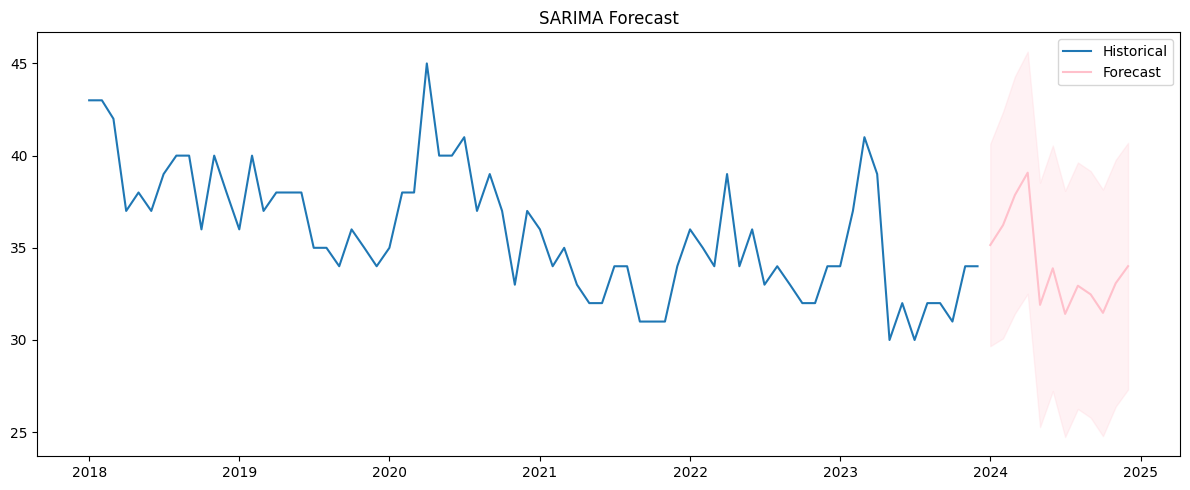

In [216]:
# fitting a SARIMA model using the best parameters identified by `auto_arima`:  
model = SARIMAX(train, 
                order=(1, 0, 1), # (p, d, q)
                seasonal_order=(1, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained model.
forecast = model_fit.get_forecast(steps=12)
indie_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Historical')
plt.plot(future_dates, indie_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('SARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.show()

### **Model Evaluation**
---

MAE: 2.16
RMSE: 2.70
MAPE: 6.31%


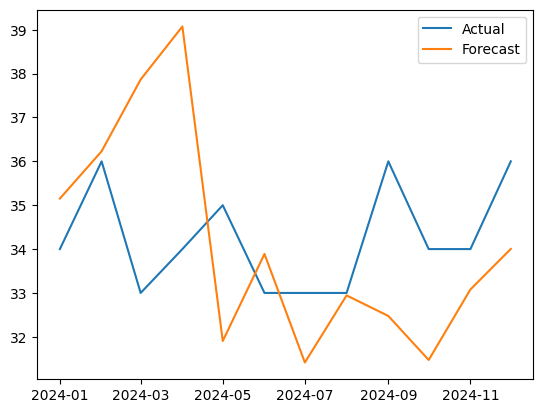

In [217]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = test
y_pred = forecast.predicted_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast.predicted_mean, label='Forecast')
plt.legend()

### **Forecasting 2025 & 2026**
---

                                      SARIMAX Results                                      
Dep. Variable:                         indie music   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                -143.793
Date:                             Sun, 25 May 2025   AIC                            295.586
Time:                                     17:03:47   BIC                            303.897
Sample:                                 01-01-2018   HQIC                           298.830
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6832      0.212      3.218      0.001       0.267       1.099
ma.L1         -0.2337      

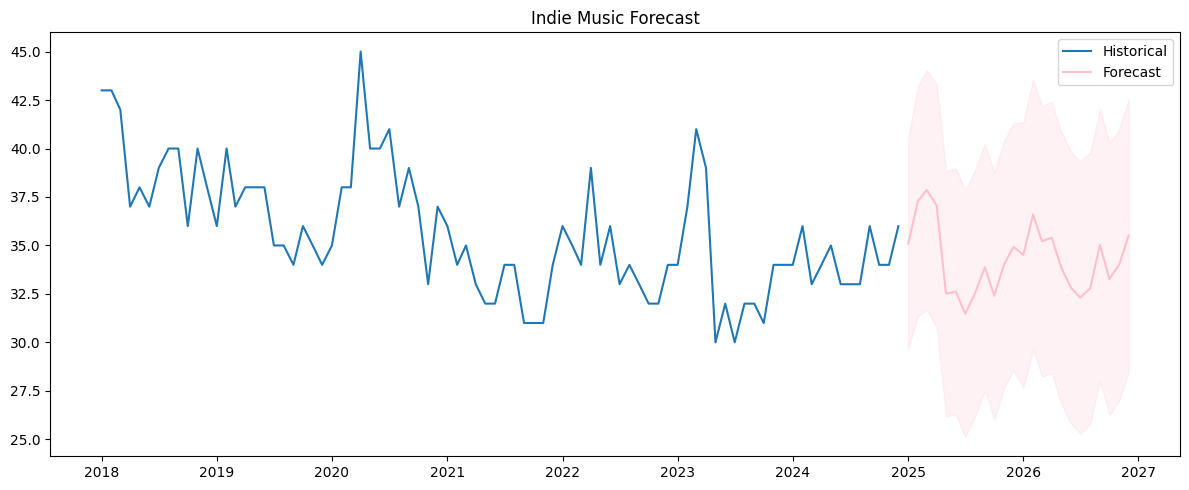

In [219]:
# fitting a SARIMA model by adjusting the parameters by evaluation the model   
model = SARIMAX(indie, 
                order=(1, 0, 1), # (p, d, q)
                seasonal_order=(1, 1, 0, 12), # (P, D, Q, m)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# forecasting the next 12 months using the trained and tested model.
forecast = model_fit.get_forecast(steps=24)
indie_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# creating a future date index for plotting the forecast.
future_dates = pd.date_range(start=indie.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')


# plotting the historical data, forecasted values, and the confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(indie, label='Historical')
plt.plot(future_dates, indie_forecast, label='Forecast', color='pink')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.title('Indie Music Forecast')
plt.legend()
plt.tight_layout()
plt.show()

- There was a notable peak around early 2020, reaching 45. Overall, the historical data suggests a general decline from 2018 to 2021, followed by a period of relative stability with some minor fluctuations.

- The forecast generally predicts a slight initial increase in early 2025, reaching around 37-38, followed by a gradual decline and stabilization around 34-35 towards the end of the forecast period.

In [70]:
indie_forecast

2025-01-01    35.902823
2025-02-01    37.196838
2025-03-01    37.488819
2025-04-01    39.065597
2025-05-01    34.986217
2025-06-01    35.846458
2025-07-01    34.895749
2025-08-01    34.721385
2025-09-01    33.960852
2025-10-01    33.505120
2025-11-01    33.240650
2025-12-01    34.689689
2026-01-01    34.927838
2026-02-01    36.465464
2026-03-01    36.124378
2026-04-01    37.641031
2026-05-01    34.710487
2026-06-01    34.999228
2026-07-01    34.291282
2026-08-01    34.186197
2026-09-01    34.262920
2026-10-01    33.496536
2026-11-01    33.307738
2026-12-01    34.891192
Freq: MS, Name: predicted_mean, dtype: float64

## **Compiling all the forecast timeseries into one**

In [71]:
hiphop = df['hip hop music']
pop = df['pop music']
country = df['country music']
rock = df['rock music']
alter = df['alternative music']
kpop = df['kpop music']
metal = df['metal music']
latin = df['latin music']
indie = df['indie music']

In [72]:
# Assume these are all Series objects with datetime index
# Example: {'indie': indie_forecast, 'pop': pop_forecast, ...}
genre_forecasts = {
    'hiphop': hiphop_forecast,
    'pop': pop_forecast,
    'country': country_forecast, 
    'rock': rock_forecast,
    'alter': alter_forecast,
    'kpop': kpop_forecast,
    'metal': metal_forecast,
    'latin': latin_forecast,
    'indie': indie_forecast
}

# Combine into a single DataFrame
forecast_df = pd.DataFrame(genre_forecasts)
forecast_df.index.name = 'date'
forecast_df.to_csv('forecasts.csv')